In [1]:
from pytorch_fid import fid_score
import lpips
import numpy as np
import torch
import torch.nn as nn
import os

import torch.nn.functional as F
import torchvision
import math

import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms

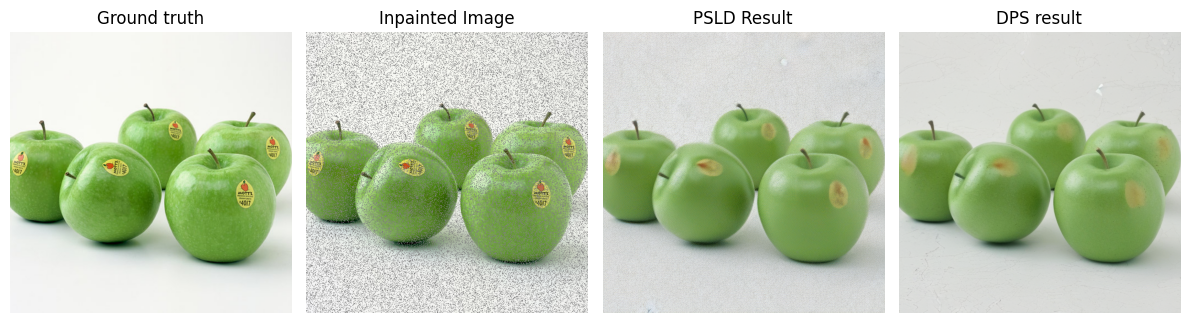

In [3]:
prefix = "ILSVRC2012_val_0000000"
ground_truth = 'example_outputs/psld/grey_rip/source'
output_path = 'example_outputs/psld'

def show_images(img_paths, titles=None):
    """ Display three images side by side with optional titles above them. """
    fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))

    for ax, img_path, title in zip(axes, img_paths, titles or [""] * len(img_paths)):
        img = read_image(img_path).float() / 255.0
        img = transforms.ToPILImage()(img)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title, fontsize=12)  # Add title above each image

    plt.tight_layout()
    plt.show()

index = 22
image_1 = f"{ground_truth}/{prefix}{index}.png"
image_2 = f"{output_path}/grey_rip/low_res/{prefix}{index}.png"
image_3 = f"{output_path}/grey_rip/recon/{prefix}{index}.png"
image_4 = f"{output_path}/null_gamma/recon/{prefix}{index}.png"

# Example usage
img_paths = [image_1, image_2, image_3, image_4]  
titles = ["Ground truth", "Inpainted Image", "PSLD Result", "DPS result"] 
show_images(img_paths, titles)

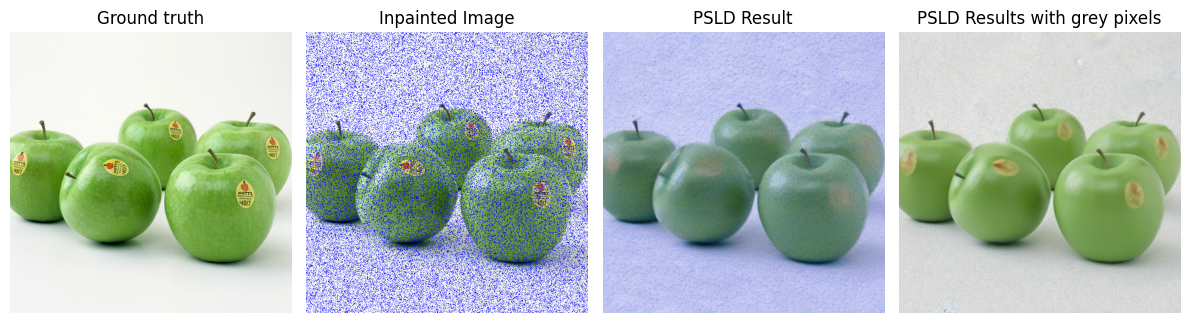

In [4]:
index = 22
image_1 = f"{ground_truth}/{prefix}{index}.png"
image_2 = f"{output_path}/blue_rip/low_res/{prefix}{index}.png"
image_3 = f"{output_path}/blue_rip/recon/{prefix}{index}.png"
image_4 = f"{output_path}/grey_rip/recon/{prefix}{index}.png"

img_paths = [image_1, image_2, image_3, image_4]
titles = ["Ground truth", "Inpainted Image", "PSLD Result", "PSLD Results with grey pixels"] 
show_images(img_paths, titles)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_and_preprocess(image_path):
  target_image = Image.open(image_path)
  transform = transforms.Compose([
      transforms.Resize((512, 512)),
      transforms.ToTensor(),
  ])
  target_image = transform(target_image)
  return target_image

def compute_metrics(true_images, output, device=device, len=25):
  fid = fid_score.calculate_fid_given_paths(paths=[true_images, output], batch_size=1, device=device, dims=2048)
  loss_fn = lpips.LPIPS(net='vgg').to(device)
  
  lpips_score, ssim_score, psnr_score = 0, 0, 0
  
  true_images = [os.path.join(true_images, f) for f in sorted(os.listdir(true_images)) if f.endswith(".png")]
  output_images = [os.path.join(output, f) for f in sorted(os.listdir(output)) if f.endswith(".png")]
  
  for true, ft in zip(true_images, output_images):


    true_tensor = read_and_preprocess(true).unsqueeze(0).to(device)
    ft_tensor = read_and_preprocess(ft).unsqueeze(0).to(device)
    
    lpips_score += loss_fn(true_tensor, ft_tensor).item()
    
    true_np = true_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    ft_np = ft_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    ssim_score += ssim(true_np, ft_np, data_range=1.0, win_size=7, channel_axis=-1)
    psnr_score += psnr(true_np, ft_np, data_range=1.0)

  ssim_score /= len
  psnr_score /= len
  lpips_score /= len
  print(f"FID: {fid}, LPIPS: {lpips_score}, PSNR: {psnr_score}, SSIM: {ssim_score}")

  return fid, lpips_score, psnr_score, ssim_score

results_dps = f"{output_path}/null_gamma/recon/"
# FID: 139.1699782914219, LPIPS: 0.43602941036224363, PSNR: 21.39428561610405, SSIM: 0.5670467615127563
fid_dps, lpips_dps, psnr_dps, ssim_dps = compute_metrics(ground_truth, results)

results_dps = f"{output_path}/blue_rip/recon/"
# FID: 139.1699782914219, LPIPS: 0.43602941036224363, PSNR: 21.39428561610405, SSIM: 0.5670467615127563
fid_dps, lpips_dps, psnr_dps, ssim_dps = compute_metrics(ground_truth, results)

results_dps = f"{output_path}/grey_rip/recon/"
fid_dps, lpips_dps, psnr_dps, ssim_dps = compute_metrics(ground_truth, results)
# FID: 139.1699782914219, LPIPS: 0.43602941036224363, PSNR: 21.39428561610405, SSIM: 0.5670467615127563

100%|██████████| 25/25 [00:00<00:00, 43.41it/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/conda/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
FID: 139.1699782914219, LPIPS: 0.43602941036224363, PSNR: 21.39428561610405, SSIM: 0.5670467615127563


100%|██████████| 25/25 [00:00<00:00, 42.67it/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
FID: 139.1699782914219, LPIPS: 0.43602941036224363, PSNR: 21.39428561610405, SSIM: 0.5670467615127563
